In [1]:
import os
import io
import bson
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.data import imread
import multiprocessing as mp
from glob import iglob


bson_file = '/Users/check4068/Desktop/算法营销作业/Assignment 3/train_example.bson'
NCORE = 16
max_images = 7069896

input_dir = os.path.abspath(os.path.join(os.getcwd(), '../input'))
base_dir = os.path.join(os.getcwd())
images_dir = os.path.join(base_dir, 'images')
bson_file = os.path.join(input_dir, bson_file)

product_count = 2
category_count = 2
picture_count = 2


def process(q, iolock):
    global product_count
    global category_count
    global picture_count
    while True:
        d = q.get()
        if d is None:
            break

        product_count += 1
        product_id = str(d['_id'])
        category_id = str(d['category_id'])

        category_dir = os.path.join(images_dir, category_id)
        if not os.path.exists(category_dir):
            category_count += 1
            try:
                os.makedirs(category_dir)
            except:
                pass

        for e, pic in enumerate(d['imgs']):
            picture_count += 1
            picture = imread(io.BytesIO(pic['picture']))
            picture_file = os.path.join(category_dir, product_id + '_' + str(e) + '.jpg')
            if not os.path.isfile(picture_file):
                plt.imsave(picture_file, picture)


q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))


data = bson.decode_file_iter(open(bson_file, 'rb'))

for c, d in tqdm(enumerate(data)):
    if (c + 1) > max_images:
        break
    q.put(d)  # blocks until q below its max size

# tell workers we're done
for _ in range(NCORE):
    q.put(None)
pool.close()
pool.join()

print('Images saved at %s' % images_dir)
print('Products: \t%d\nCategories: \t%d\nPictures: \t%d' % (product_count, category_count, picture_count))

file = open(os.path.join(base_dir, 'retrained_labels.txt'), 'w')

rootdir_glob = images_dir + '/**/*'
folder_list = [f for f in iglob(rootdir_glob, recursive=True) if os.path.isdir(f)]
for folder in folder_list:
    category = folder.split('/')[-1]
    file.write(category + '\n')

file.close()

print('"retrained_labels.txt" saved at %s' % base_dir)

82it [00:00, 101.84it/s]


Images saved at /Users/check4068/images
Products: 	2
Categories: 	2
Pictures: 	2
"retrained_labels.txt" saved at /Users/check4068


In [4]:
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
import pandas as pd
# Simple data processing

data = bson.decode_file_iter(open('/Users/check4068/Desktop/算法营销作业/Assignment 3/train_example.bson', 'rb'))

prod_to_category = dict()

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        # do something with the picture, etc
prod_to_category
prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [5]:
prod_to_category

,category_id
_id,
0,1000010653
1,1000010653
2,1000004079
3,1000004141
4,1000015539
...,...
95,1000010653
97,1000010683
98,1000010667


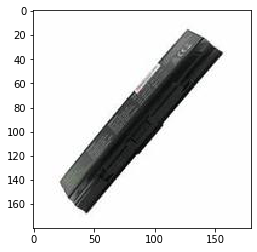

In [6]:
plt.imshow(picture);